In [30]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
%matplotlib inline
from astropy.table import Table
from george.modeling import Model


In [2]:
tab = Table.read('Data/SN1987A_photometry.csv',format='ascii')
band = tab['band']
time = tab['time']
mag = tab['magnitude']
band_name = np.unique(band)
tab

event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
str7,float64,float64,int64,int64,str1,int64,int64,str104
SN1987A,46849.44,6.36,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46849.62,6.11,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.89,--,--,B,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.06,--,--,U,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.81,--,--,V,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.74,--,--,B,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.29,--,--,I,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.37,--,--,R,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,3.95,--,--,U,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"


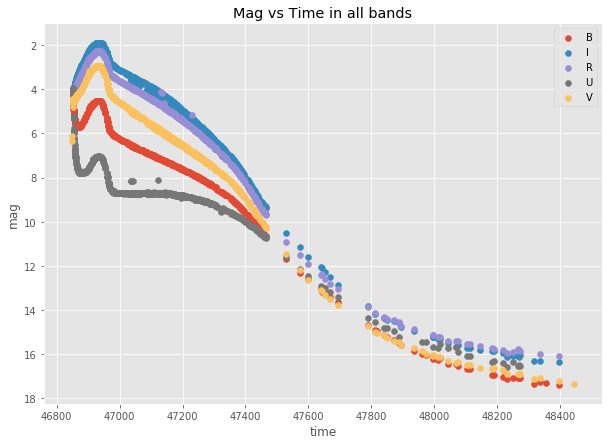

In [3]:
plt.style.use('ggplot')
plt.figure(figsize = (10,7))
for i in range(len(band_name)):
    plt.scatter(time[band == band_name[i]], mag[band == band_name[i]], label = str(band_name[i]))
    plt.legend()
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()

In [4]:
mask = (time>46800) & (time < 47200)
mtab = tab[mask]
mtime = mtab['time']
mmag = mtab['magnitude']
mband = mtab['band']
min_time = np.min(mtime)
mtime = mtime - min_time # to make time start from zero

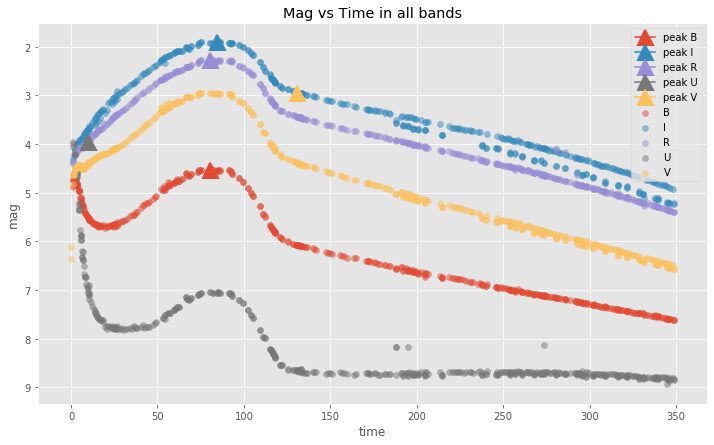

In [5]:
plt.style.use('ggplot')
plt.figure(figsize = (12,7))
for i in range(len(band_name)):
    plt.scatter(mtime[mband == band_name[i]], mmag[mband == band_name[i]], label = str(band_name[i]), alpha = 0.5)
    #min_index = np.argmin(mmag[mband == band_name[i]])
    min_mag = np.min(mmag[mband == band_name[i]])
    plt.plot(np.median(mtime[mmag == min_mag]), min_mag , marker ='^', label = 'peak ' + str(band_name[i]), ms=15.,  mew=2)
    plt.legend(loc = 'best')
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()


In [44]:
class mean_model(Model):
    parameter_names = ("a1", "b1", "c1","a2", "b2", "c2" )
    
    def get_value(self, t):
        magnitude = []
        for x in t:
            if x < 115:
                magnitude.append(self.a1*x**2 + self.b1*x + self.c1)
            else:
                magnitude.append(self.a2*x**2 + self.b2*x + self.c2)
        return np.array(magnitude)

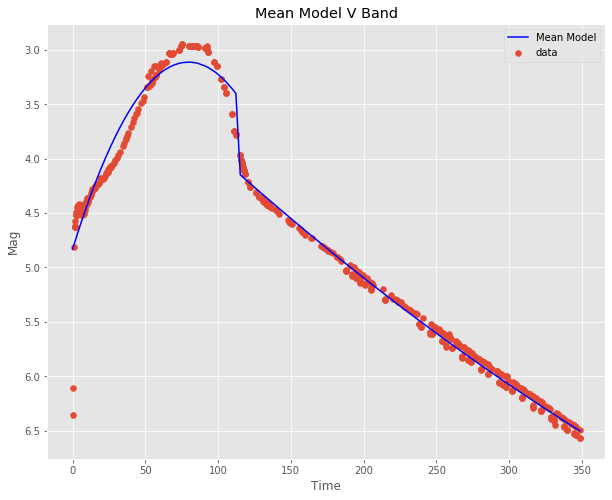

In [45]:
v_mtime = np.asarray(mtime[mband == 'V'])
v_mmag =  np.asarray(mmag[mband == 'V'])
A1,B1,C1 = np.polyfit(v_mtime[v_mtime<115], v_mmag[v_mtime<115], 2)
A2,B2,C2  = np.polyfit(v_mtime[v_mtime>115], v_mmag[v_mtime>115], 2)
model_flux = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2).get_value(v_mtime)

#plot the model on top of the original data  
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.scatter(v_mtime, v_mmag, label = "data")
plt.plot(v_mtime, model_flux,'b-', label = "Mean Model")
plt.title('Mean Model V Band')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()

In [46]:
print(np.shape(v_mmag))

(456,)


[ 2.71116252e-04 -4.31769322e-02  4.83143624e+00 -7.30072808e-06
  1.34684156e-02  2.69319695e+00  4.24849524e+00]


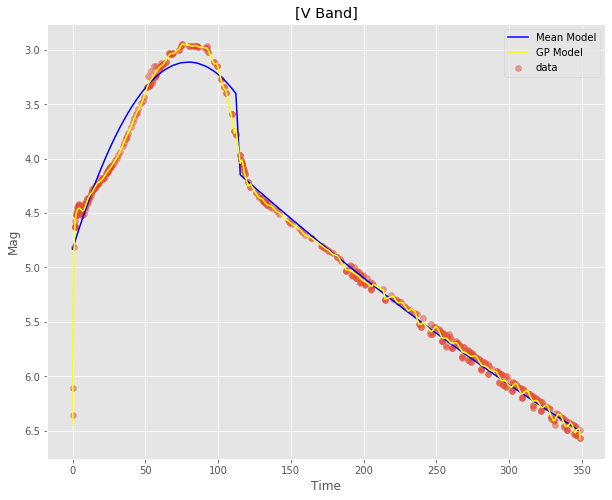

In [59]:
MEAN = mean_model(a1=A1, b1= B1, c1=C1, a2=A2, b2=B2, c2=C2)
k = kernels.ExpSquaredKernel(70.0)

gp = george.GP(k, mean = MEAN)
gp.compute(v_mtime)

print(gp.get_parameter_vector())


mu,var = gp.predict(v_mmag,v_mtime,return_var=True)


plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.scatter(v_mtime, v_mmag, label = "data", alpha = 0.5)
plt.plot(v_mtime, model_flux,'b-', label = "Mean Model")
plt.plot(v_mtime, mu, color="yellow", label = 'GP Model ')
plt.title('[V Band]')
plt.xlabel("Time")
plt.ylabel("Mag")
plt.legend(loc='best')
plt.gca().invert_yaxis()

